# Locally Connected Autoencoder Neural Network based denoising

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from torch import nn, optim, no_grad

from line_cube_denoising.dataset import CubeDataset
from line_cube_denoising.networks import LocalAutoencoder
from line_cube_denoising.training import ReconstructionLoss, InformedLoss, LearningParameters, learning_procedure

data_path = os.path.join(os.getcwd(), "..", "cubes", "preprocessing")
results_path = os.path.join(os.getcwd(), "out_dense_ae")

In [2]:
# Creation of the dataset

line_name = "12cn10_small"

hdu = fits.open(os.path.join(data_path, line_name, f"{line_name}.fits"))[0]
cube = hdu.data
header = hdu.header

mask_cube = fits.open(os.path.join(data_path, line_name, f"{line_name}_mask.fits"))[0].data
noise_map = fits.open(os.path.join(data_path, line_name, f"{line_name}_noise_map.fits"))[0].data

cube = cube.astype(np.float32)
mask_cube = mask_cube.astype(np.float32)
noise_map = noise_map.astype(np.float32)

In [3]:
channels_range = (None, None)
# n_inputs = channels_range[1] - channels_range[0]
n_inputs = cube.shape[0]

dataset = CubeDataset(
    cube[slice(*channels_range)],
    mask_cube[slice(*channels_range)],
    noise_map
)

nx, ny, nz = dataset.nx, dataset.ny, dataset.nz

Dataset created: 80 features, 141050 samples


In [4]:
# Creation of the architecture

win_size = 5
bottleneck_size = round(0.75*n_inputs)
half_description_by_win = [win_size, 5*win_size, 5*win_size, 5*win_size]
activation = nn.ELU()

model = LocalAutoencoder(
    n_inputs,
    bottleneck_size,
    win_size,
    half_description_by_win,
    activation,
)

In [5]:
# Training parameters

normalize = True
# loss = ReconstructionLoss(normalize=normalize)
loss = InformedLoss(normalize=normalize)

epochs = 10 # TODO
batch_size = 500

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr)

gamma = 0.95
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

learning_parameters = LearningParameters(
    loss,
    epochs,
    batch_size,
    optimizer,
    scheduler
)

In [6]:
# Training procedure

val_frac = 0.2
seed = None

results = learning_procedure(
    model,
    dataset,
    learning_parameters,
    val_frac=val_frac,
    seed = None,
    verbose=False,
)

Number of epochs: 10
.........|

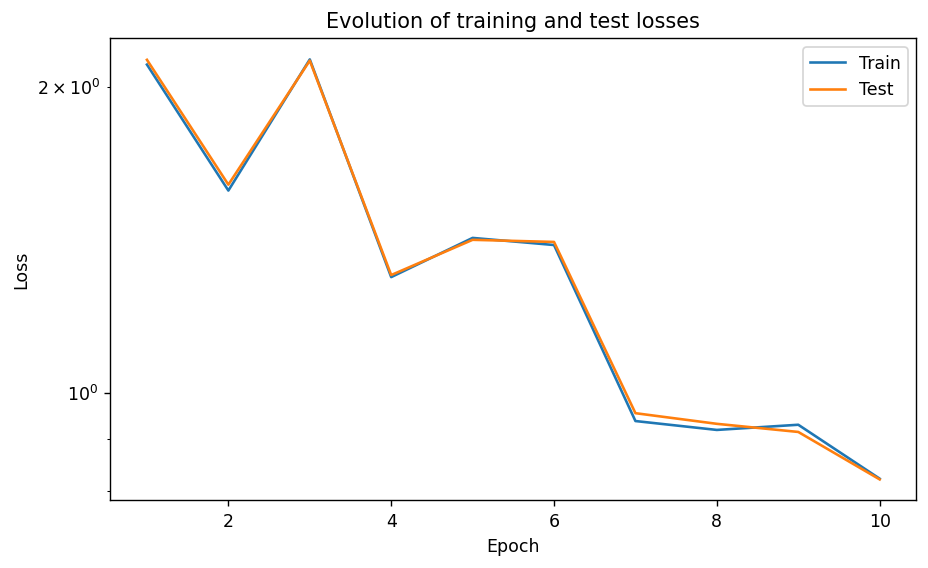

In [7]:
# Results

plt.figure(figsize=(1.3*6.4, 4.8), dpi=125)

plt.semilogy(list(range(1, epochs+1)), results["train_loss"], label="Train")
plt.semilogy(list(range(1, epochs+1)), results["val_loss"], label="Test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of training and test losses")

plt.legend()

plt.show()

In [8]:
x, mask, sigma = dataset[:]

model.eval()
with no_grad():
    x_hat, y_hat = model.forward(x)

# Conversion to NumPy
x = x.detach().numpy()
x_hat = x_hat.detach().numpy()
y_hat = y_hat.detach().numpy()
sigma = sigma.detach().numpy()

# Reshaping
X = x.T.reshape(nz, ny, nx)
X_hat = x_hat.T.reshape(nz, ny, nx)
Y_hat = y_hat.T.reshape(bottleneck_size, ny, nx)
Sigma = sigma.reshape(ny, nx)

# Residuals
Residuals = X - X_hat

## Cubes save

In [9]:
if not os.path.isdir(f"output_{line_name}"):
    os.mkdir(f"output_{line_name}")

fits.PrimaryHDU(X, header).writeto(os.path.join(f"output_{line_name}", "input.fits"), overwrite=True)
fits.PrimaryHDU(X_hat, header).writeto(os.path.join(f"output_{line_name}", "output.fits"), overwrite=True)
fits.PrimaryHDU(Residuals, header).writeto(os.path.join(f"output_{line_name}", "residuals.fits"), overwrite=True)

## Model save

In [10]:
model.save(f"model_{line_name}")